# Elevation Covariate

Read elevation data by a bounding box tile for stacking with other covariates in analysis.
Initial version uses SRTM v3 available as Cloud Optimized Geotiffs in MAAP.


1. Get bbox of tile
2. Buffer/extend bbox at min 1 pixel (can be more, no prob)3
3. Read the elev data
4. Write elevation data to /tmp in order to read back in as a gdal dataset that gdal.DEMProcessing wants.
5. Clip and write_band for elev
6. Compute the 3 covars in memory with for loop; for covar in covars: calc, clip, write_band
    a. use GDAL DEMProcessing or gdaldem via python os.subprocess.run()


In [ ]:
if False:
    #only run this block if needed in a new workspace, TODO: add to conda env.yml
    %conda install -yq -c conda-forge rasterio geopandas folium rio-cogeo rio-tiler

In [2]:
import sys
import json
import os
from pprint import pprint

from osgeo import gdal

import boto3

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import numpy.ma as ma
from pyproj import Proj, Transformer



import geopandas as gpd
import shapely as shp
import folium
from shapely.geometry import box
from fiona.crs import from_epsg
import rasterio as rio
from rasterio.session import AWSSession 
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import * #TODO: limit to specific needed modules
from rasterio.merge import merge
from rasterio import windows
from rasterio.io import MemoryFile
from rasterio.crs import CRS
from rasterio.vrt import WarpedVRT
from rio_cogeo.profiles import cog_profiles
#from rio_tiler import create_cutline
from rio_cogeo.cogeo import cog_translate

from maap.maap import MAAP
maap = MAAP()

# WKT 'out_crs' projection info will be stored in a file

### 1. Get the bbox of the tile

In [3]:
# Get bbox extent
geojson_path = '/projects/maap-users/alexdevseed/boreal_tiles_latlong.geojson'
#bbox_ID = 40349 #ID to match covar testing
bbox_ID = 40819
#bbox_ID = 40312 #temp testing coastal

tile_index = gpd.read_file(geojson_path)
buffer = 0.001
geom_orig = tile_index['geometry'].iloc[(bbox_ID-1)]
in_geom_buffered = geom_orig.buffer(buffer)
in_bbox = geom_orig.bounds

print(in_bbox)

(-117.0, 50.3, -116.7, 50.6)


In [4]:
# Set the final output projection
prj_file = '/projects/maap-users/alexdevseed/boreal_tiles_albers.prj'
with open(prj_file, 'r') as prj:
    wkt = prj.read()
    
out_crs = CRS.from_wkt(wkt)
print(out_crs.to_dict())

{'proj': 'aea', 'lat_0': 40, 'lon_0': 180, 'lat_1': 50, 'lat_2': 70, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}


Use the bbox to find DEMs

In [5]:
# Read the copernicus index file
cop30dem_geojson = '/projects/maap-users/alexdevseed/dem30m_tiles.geojson'
cop30dem = gpd.read_file(cop30dem_geojson)

# intersect with the bbox tile
selection = cop30dem.loc[cop30dem.intersects(in_geom_buffered)]
selection.head()

,id,key,s3,geometry
5100,Copernicus_DSM_COG_10_N50_00_W118_00_DEM,Copernicus_DSM_COG_10_N50_00_W118_00_DEM/Coper...,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...,"POLYGON ((-118.00021 50.00014, -118.00021 51.0..."
5101,Copernicus_DSM_COG_10_N50_00_W117_00_DEM,Copernicus_DSM_COG_10_N50_00_W117_00_DEM/Coper...,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...,"POLYGON ((-117.00021 50.00014, -117.00021 51.0..."


### 2. Buffer/extend bbox

In [6]:
# Reformat bbox
#bbox_list =  [float(value) for value in converted_in_bbox.split(',')]
bbox_list = in_bbox
print(bbox_list)
# Elevation covar calc will require consideration of tile edges. We want seemlessness across adjacent tiles
# To handle this, use this buffered bbox to extract elevation data, process it to the covars, then clip by original bbox
bbox_buffered = in_geom_buffered.bounds
# TODO: Probably need a 'bbox_buffered_list' from the above geometry...
print(bbox_buffered)

# Get centroid of bbox
#center = shp.geometry.box(*bbox_list).centroid
center = in_geom_buffered.centroid

m = folium.Map(
    # Zoom to center
    #location=[center.y,center.x],
    # Zoom to corner
    location=[bbox_list[1], bbox_list[2]],
    tiles="cartodbpositron",
    zoom_start=15,
)

bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'}
bbox_buf_style = {'fillColor': '#fdae61', 'color': '#fdae61'}

folium.GeoJson(selection, name="tiles").add_to(m)
folium.GeoJson(shp.geometry.box(*bbox_list), 
               name="bbox",
               style_function=lambda x:bbox_style).add_to(m)
folium.GeoJson(shp.geometry.box(*bbox_buffered), 
               name="bbox_buf",
               style_function=lambda x:bbox_buf_style).add_to(m)
m

(-117.0, 50.3, -116.7, 50.6)
(-117.001, 50.299, -116.699, 50.601)


### Read the elevation data (for the bbox)

For each result read the subwindow. After reading all the subwindows, merge them together as a single  array. 

In [7]:
# Set up and aws session
aws_session = AWSSession(boto3.Session())
# Get the s3 urls to the granules
file_s3 = selection["s3"].to_list()
file_s3.sort()
print("The DEM filenames for the bbox:\n", '\n'.join(file_s3))


The DEM filenames for the bbox:
 s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N50_00_W117_00_DEM/Copernicus_DSM_COG_10_N50_00_W117_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N50_00_W118_00_DEM/Copernicus_DSM_COG_10_N50_00_W118_00_DEM.tif


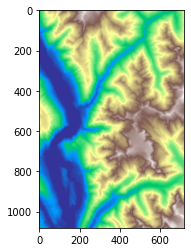

<AxesSubplot:>

In [8]:
if False:
    # prove that we can read the aws files, an overview should be faster
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rio.Env(aws_session):
        with rio.open(file_s3[0], 'r') as src:
            # List of overviews from biggest to smallest
            oviews = src.overviews(1)

            # Retrieve the smallest thumbnail
            oview = oviews[1]
            thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    show(thumbnail)

# Create a mosaic from all the images
with rio.Env(aws_session):
    sources = [rio.open(raster, 'r') for raster in file_s3]    
    
# Merge the source files
# TODO: test passing all s3 sources
mosaic, out_trans = merge(sources, bounds = bbox_list)

# Mask the NoData values so it can be plotted correctly
# Since the DEM doesn't have nodata we need a Coastal/Water mask if we want to drop those pixels
# TODO - potentially use a slope = 0 to mask water?
#masked_mosaic = ma.masked_values(mosaic, int(sources[0].nodatavals[0]))
show(mosaic, cmap = 'terrain')

### Write Results as Cloud Optimized Geotiff
Write elevation data to /tmp in order to read back in as a gdal dataset (that gdal.DEMProcessing wants) in order to calc that remaining topo covars.

In [9]:
# Functions 
# copied from pygeotools/iolib.py TODO: full citation
# Q: direct import, but pygeotools isn't in conda-forge OR reimplement
#Given input dataset, return a masked array for the input band
def ds_getma(ds, bnum=1):
    """Get masked array from input GDAL Dataset
    Parameters
    ----------
    ds : gdal.Dataset 
        Input GDAL Datset
    bnum : int, optional
        Band number
    
    Returns
    -------
    np.ma.array    
        Masked array containing raster values
    """
    b = ds.GetRasterBand(bnum)
    return b_getma(b)

#Given input band, return a masked array
def b_getma(b):
    """Get masked array from input GDAL Band
    Parameters
    ----------
    b : gdal.Band 
        Input GDAL Band 
    
    Returns
    -------
    np.ma.array    
        Masked array containing raster values
    """
    b_ndv = get_ndv_b(b)
    #bma = np.ma.masked_equal(b.ReadAsArray(), b_ndv)
    #This is more appropriate for float, handles precision issues
    bma = np.ma.masked_values(b.ReadAsArray(), b_ndv)
    return bma
#Return nodata value for GDAL band
def get_ndv_b(b):
    """Get NoData value for GDAL band.
    If NoDataValue is not set in the band, 
    extract upper left and lower right pixel values.
    Otherwise assume NoDataValue is 0.
 
    Parameters
    ----------
    b : GDALRasterBand object 
        This is the input band.
 
    Returns
    -------
    b_ndv : float 
        NoData value 
    """

    b_ndv = b.GetNoDataValue()
    if b_ndv is None:
        #Check ul pixel for ndv
        ns = b.XSize
        nl = b.YSize
        ul = float(b.ReadAsArray(0, 0, 1, 1))
        #ur = float(b.ReadAsArray(ns-1, 0, 1, 1))
        lr = float(b.ReadAsArray(ns-1, nl-1, 1, 1))
        #ll = float(b.ReadAsArray(0, nl-1, 1, 1))
        #Probably better to use 3/4 corner criterion
        #if ul == ur == lr == ll:
        if np.isnan(ul) or ul == lr:
            b_ndv = ul
        else:
            #Assume ndv is 0
            b_ndv = 0
    elif np.isnan(b_ndv):
        b_dt = gdal.GetDataTypeName(b.DataType)
        if 'Float' in b_dt:
            b_ndv = np.nan
        else:
            b_ndv = 0
    print("NoData Value: ",b_ndv)
    return b_ndv

In [10]:


# copied from 3.1.2
# TODO: create library of functions used acrosss notebooks
def define_raster(file, in_bbox, epsg="epsg:4326"):
    '''Read the first raster to get its transform and crs'''
    with rio.open(file, 'r') as f:
        bbox = transform_bounds(epsg, f.crs, *in_bbox)
        #w = windows.from_bounds(*bbox, transform=f.transform)
        #band = f.read(1, window=w, masked=True)
        band, out_transform = merge([f],bounds=bbox)
    return f.crs, out_transform
        
def MaskArrays(file, in_bbox, epsg="epsg:4326"):
    '''Read a window of data from the raster matching the tile bbox'''
    print(file)
    with rio.open(file, 'r') as f:
        bbox = transform_bounds(epsg, f.crs, *in_bbox)
        #w = windows.from_bounds(*bbox, transform=f.transform)
        #band = f.read(1, window=w, masked=True)
        band, out_transform = merge([f],bounds=bbox)
    return np.ma.masked_array(band[0].astype(float), mask=f.nodata)

def slopeMask(slope_ma):
    m = np.zeros_like(slope_ma)
    m = np.where(slope_ma > 0, 1, m)
    print("Slope mask created")
    return m

# Specify GeoTIFF structure
def write_cog(stack, out_fn, in_crs, src_transform, bandnames, out_crs=None, clip_geom=None, clip_crs=None):
    '''Write a cloud optimized geotiff with compression from a numpy stack of bands with labels
    Reproject if needed, Clip to bounding box if needed'''
    
    if out_crs is None:
        out_crs = in_crs
    
    vrt_params = {}
    if out_crs is not None:
        vrt_params["crs"] = out_crs
        vrt_params["src_crs"] = in_crs
        vrt_params["dtype"] = str(stack.dtype)
        vrt_params["nodata"] = np.nan
    print('Orig stack shape: ',stack.shape)
    
    # Set the profile for the in memory raster based on the ndarry stack
    src_profile = dict(
        driver="GTiff",
        height=stack.shape[1],
        width=stack.shape[2],
        count=stack.shape[0],
        dtype=stack.dtype,
        crs=in_crs,
        transform=src_transform,
        nodata=np.nan)
        
    # Get the rio-cogeo profile for deflate compression, modify some of the options
    dst_profile = cog_profiles.get("deflate")
    dst_profile['blockxsize']=256
    dst_profile['blockysize']=256
    dst_profile['predictor']=2
    dst_profile['zlevel']=7
    
    with MemoryFile() as memfile:
        with memfile.open(**src_profile) as mem:
            # Populate the input file with NumPy array
            # HERE; this memory file can be reprojected then saved
            mem.write(stack)

            #if clip_geom is not None:
                # Do the clip to geometry (rasterio takes this; not in_bbox)
                # # https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
                #mem, clipped_transform = rasterio.mask.mask(mem, clip_geom, crop=True)
                #out_meta = mem.meta
                #out_meta.update({"driver": "GTiff",
                #                 "height": mem.shape[1],
                #                 "width": mem.shape[2],
                #                 "transform": clipped_transform})
                #vrt_params["cutline"] = create_cutline(mem, clip_geom, geometry_crs="epsg:4326")
            
                               
            print('Writing img to memory...')
            
            for n in range(len(bandnames)):
                mem.set_band_description(n+1, bandnames[n])
        
            with WarpedVRT(mem,  **vrt_params) as vrt:
                print(vrt.profile)
                cog_translate(
                    vrt,
                    # To avoid rewriting over the infile
                    out_fn,
                    dst_profile,
                    add_mask=True,
                    in_memory=True,
                    quiet=False)

    print('Image written to disk: ', out_fn)

In [11]:
%%time

# Writing tmp elevation COG so that we can read 

# TODO: Reproject so that covars are more accurate
# TODO: format outname correctly to coincide with Landsat covars

data_path = "/projects/tmp"
if (not os.path.isdir(data_path)): os.mkdir(data_path)
tileid = '_'.join(['Copernicus', str(bbox_ID)])
ext = "covars_cog.tif"  
dem_cog_fn = os.path.join(data_path, "_".join([tileid, ext]))

#write_cog(mosaic, dem_cog_fn, sources[0].crs, out_trans, ["elevation"])

CPU times: user 41 µs, sys: 22 µs, total: 63 µs
Wall time: 49.8 µs


In [12]:
write_cog(mosaic, dem_cog_fn, sources[0].crs, out_trans, ["elevation"], out_crs=out_crs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  """Entry point for launching an IPython kernel.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/22a70ee0-53a2-42b7-95d2-bdb7bd438d46/22a70ee0-53a2-42b7-95d2-bdb7bd438d46.tif)' mode='r'>
Adding overviews...
Updating dataset tags...
Writing output to: /projects/tmp/Copernicus_40819_covars_cog.tif


Orig stack shape:  (1, 1081, 720)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'float32', 'nodata': nan, 'width': 1296, 'height': 1209, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.517412191399398, 0.0, 3829371.7999158837,
       0.0, -30.517412191399398, 3119800.8903255877), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}
Image written to disk:  /projects/tmp/Copernicus_40819_covars_cog.tif


### Derive topographic covariates from DEM
This step uses gdaldem to access the DEM COG, calc a topo covar, and write each covariate to a separate COG

In [13]:
topo_stack_cog_fn = os.path.join(os.path.splitext(dem_cog_fn)[0] + '_topo_stack.tif')

def make_topo_stack_cog(dem_fn, tsri_cog_fn):
    '''Calcs the topo covars, returns them as masked arrays, masks all where slope=0, stacks, clips, writes
    '''
    print("Opening DEM...")
    dem_ds = gdal.Open(str(dem_fn))
    dem_ma = ds_getma(dem_ds)

    # Slope
    print("Calculating Slope...")
    slope_ds = gdal.DEMProcessing('', dem_ds, 'slope', format='MEM')
    slope_ma = ds_getma(slope_ds)
    slope_ma = np.ma.masked_where(slope_ma==0, slope_ma)
    
    # TPI <--- ideally, updated this to standardized multi-scale TPI
    print("Calculating TPI...")
    tpi_ds = gdal.DEMProcessing('', dem_ds, 'tpi', format='MEM')
    tpi_ma = ds_getma(tpi_ds)
    tpi_ma = np.ma.masked_where(slope_ma==0, tpi_ma)
    
    # TSRI
    # topo solar radiation index (a transformation of aspect; 0 - 1) TSRI = 0.5−cos((π/180)(aspect−30))/2
    # Matasci et al 2018: https://doi.org/10.1016/j.rse.2017.12.020
    print("Calculating TSRI...")
    aspect_ds = gdal.DEMProcessing('', dem_ds, 'aspect', format='MEM')
    aspect_ma = ds_getma(aspect_ds)
    tsri_ma = 0.5 - np.cos((np.pi/180.) * (aspect_ma - 30.))/2.
    tsri_ma = np.ma.masked_where(tsri_ma==-9999, tsri_ma)
    
    # Try this for removing water
    valid_mask = slopeMask(slope_ma)
    
    # Create topo_covar file list <-- below is actually a masked array list, not a file list
    topo_covar_file_list = [dem_ma, slope_ma, tsri_ma, tpi_ma, valid_mask]
    
    # Close the gdal datasets
    dem_ds = slope_ds = aspect_ds = tpi_ds = None
    
    # TODO: CLip stack to in_bbox
    # TODO: Mask the file with the in_bbox?! - MaskArrays wants a file list, not a masked array list (which is what I have given it...)
    #topo_covar_file_list_bbox = [MaskArrays(topo_covar_file_list[i], in_bbox) for i in range(len(topo_covar_file_list))]
    
    # Stack
    # move axis of the stack so bands is first
    topo_stack = np.transpose([dem_ma, slope_ma, tsri_ma, tpi_ma, valid_mask], [0,1,2])
    
    #topo_stack = np.transpose(topo_covar_file_list_bbox, [0,1,2])
    topo_stack_names = ["elevation","slope","tsri","tpi", "slopemask"]
    write_cog(topo_stack, tsri_cog_fn, sources[0].crs, out_trans, topo_stack_names)
    
    return(topo_stack, topo_stack_names)

topo_stack, topo_stack_names = make_topo_stack_cog(dem_cog_fn, topo_stack_cog_fn)

print("Type: ", topo_stack.dtype)


Opening DEM...
NoData Value:  nan
Calculating Slope...
NoData Value:  -9999.0
Calculating TPI...
NoData Value:  -9999.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/d0c20c8f-3e6c-4c70-908d-c76d77ea0231/d0c20c8f-3e6c-4c70-908d-c76d77ea0231.tif)' mode='r'>


Calculating TSRI...
NoData Value:  -9999.0
Slope mask created
Orig stack shape:  (5, 1209, 1296)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'float32', 'nodata': nan, 'width': 1505, 'height': 936, 'count': 5, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00035879179019744916, 0.0, -117.0,
       0.0, -0.00035879179019744916, 50.6), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Adding overviews...
Updating dataset tags...
Writing output to: /projects/tmp/Copernicus_40819_covars_cog_topo_stack.tif


Image written to disk:  /projects/tmp/Copernicus_40819_covars_cog_topo_stack.tif
Type:  float32


(5, 1209, 1296)
nan nan
nan nan
0.0 1.0
nan nan
0.0 1.0


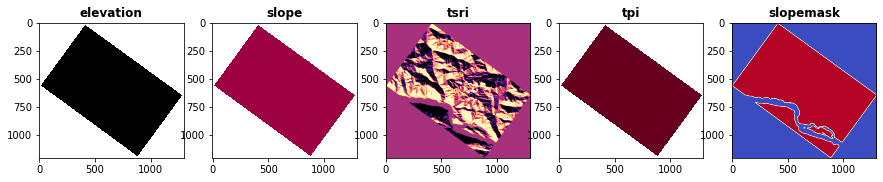

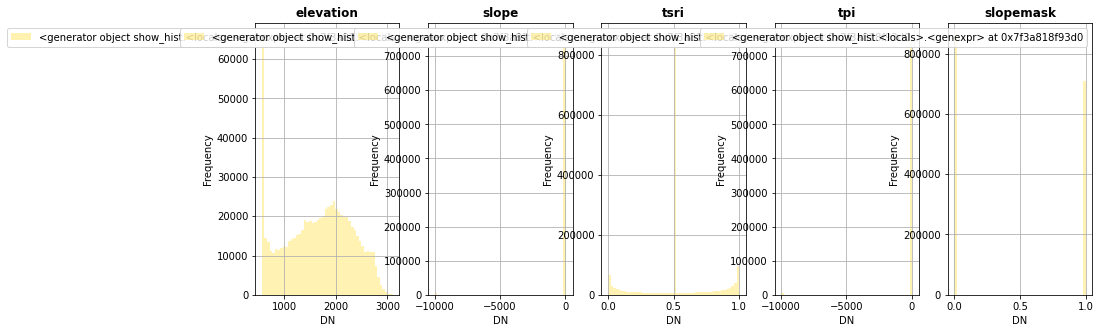

In [14]:
# This should work once you figure out the move axis of the stack: need 3 bands
n: int = len(topo_stack)
topo_cmaps = ["bone","Spectral", "magma", "RdBu", "coolwarm"]
print(topo_stack.shape)

fig, axes = plt.subplots(1,n, figsize=(n*3,5))

for i in range(n):
    print(topo_stack[i].min(), topo_stack[i].max())
    show(topo_stack[i], ax=axes[i], cmap=topo_cmaps[i], clim=(np.percentile(topo_stack[i], 10), np.percentile(topo_stack[i], 90)), title=topo_stack_names[i])


from rasterio.plot import show_hist

fig, axes = plt.subplots(1,n, figsize=(n*3,5))

for i in range(n):
    show_hist(topo_stack[i], ax=axes[i],  title=topo_stack_names[i], bins=50, lw=0.0, stacked=True, alpha=0.3)